This code is rewritten for python 3 from the following MATLAB code: ./181227_analysis_conn-based_ax_cuts/getP7synsinfofrommatfile_FD_conn_based_ax_cuts.m

In [1]:
import numpy as np
from scipy import optimize
import scipy.io as scio
import scipy.stats as st
import random
import os
import xlrd
import json
import time
import matplotlib.pyplot as plt

In [2]:
# Get connectivity info for all climbing fiber segments that innervate the fully reconstructed Purkinje cell
raw_dat_fname = './data/raw_connectivity_data/allSynapsePropertiesPC1Inputs_NEW_11-4-2016.mat'
input_prop_dict = scio.loadmat(raw_dat_fname)
input_properties = input_prop_dict['inputproperties']

VASTID = input_properties[:,0]
xsmip3 = input_properties[:,1]
ysmip3 = input_properties[:,2]
zs = input_properties[:,3]
targID = input_properties[:,4]
isInPCL = input_properties[:,5]

In [3]:
# Set font size for figures
FS = 40
dFS = 10

In [4]:
# Get list of unique inputs
uinputs = list(set(VASTID))
# Get list of unique targets
utarg = list(set(targID))

In [5]:
# Filter axons based on synaptic connectivity, so that only axons with
# climbing-fiber-like connectivity remain in the analysis
synapsecutoff = 5
# ROUNDING UP FROM MAXIMUM OF HYPERPLANE INTERVALS GIVEN BY TWO
# CLUSTERING METHODS
pcfraccutoff = 0.7

In [6]:
# Apply a filter based on total number of synapses formed in the volume
nsyns_ids = []
nsyns_nsyns = []
nsyns_npcsyns = []
inputsltcutoffsyns   = []
inputsltPCfraccutoff = []
for inid in uinputs:
    # Get all syns for that input
    rowssyns = [i for i,q in enumerate(VASTID) if q == inid]
    nsyns    = len(rowssyns)
    # Get number of total targets that are PCs
    targs    = [targID[q] for q in rowssyns]
    nPCsyns  = len([q for q in targs if q != -999])
    nsyns_ids.append(inid)
    nsyns_nsyns.append(nsyns)
    nsyns_npcsyns.append(nPCsyns)
    # Find axons that make fewer than the cutoff number of synapses
    if nsyns < synapsecutoff:
        inputsltcutoffsyns.append(inid)
#         print('ID {0}, {1} synapses total'.format(inid,nsyns)) # debugging

nsyninfo = {'vastid':nsyns_ids,'nsyns_tot':nsyns_nsyns,'nsyns_pc_targs':nsyns_npcsyns}
print('number of segments removed because they formed less than 5 synapses total in the volume: {0}'.format(len(inputsltcutoffsyns)))

number of segments removed because they formed less than 5 synapses total in the volume: 2


In [7]:
# Apply a filter based on the fraction of synapses formed on Purkinje cells
fracPCsyns = [nsyninfo['nsyns_pc_targs'][q]/nsyninfo['nsyns_tot'][q] for q in range(len(nsyninfo['nsyns_pc_targs']))]
ltcutoff = [i for i,q in enumerate(fracPCsyns) if q < pcfraccutoff]
inputsltPCfraccutoff = [nsyninfo['vastid'][q] for q in ltcutoff]
# inputsltPCfraccutoff = nsyninfo(find(fracPCsyns < pcfraccutoff),1);
# size(inputsltPCfraccutoff)
# print(len(list(set(inputsltPCfraccutoff)))) # debugging

# Flag axons that don't pass both filters for removal
inputstocut = list(set(inputsltPCfraccutoff + inputsltcutoffsyns))
inputstocut.sort()
# print(inputstocut)

# Save list of axons to remove
axs_to_remove_fname = './data/cut_axons/p7_axons_to_remove_lt_{0}_syns_lt_{1}pc_PC_targets.txt'.format(synapsecutoff,pcfraccutoff*100)
with open(axs_to_remove_fname,'w') as f:
    for i in inputstocut:
        f.write('{0}\n'.format(i))

In [8]:
# Apply the cutoffs to the data and analyze the remaining axons
rowstokeep_nsi = [i for i,q in enumerate(nsyninfo['vastid']) if not q in inputstocut]
nvnew = [nsyninfo['vastid'][q] for q in rowstokeep_nsi]
nnsnew = [nsyninfo['nsyns_tot'][q] for q in rowstokeep_nsi]
nnpcsnew = [nsyninfo['nsyns_pc_targs'][q] for q in rowstokeep_nsi]
nsyninfonew = {'vastid':nvnew,'nsyns_tot':nnsnew,'nsyns_pc_targs':nnpcsnew}

rowstokeep_conn = [i for i,q in enumerate(VASTID) if not q in inputstocut]
VASTIDnew  = [VASTID[q] for q in rowstokeep_conn]
targIDnew = [targID[q] for q in rowstokeep_conn]
xsnew = [xsmip3[q] for q in rowstokeep_conn]
ysnew = [ysmip3[q] for q in rowstokeep_conn]
zsnew = [zs[q] for q in rowstokeep_conn]
isInPCLnew = [isInPCL[q] for q in rowstokeep_conn]

In [9]:
synsontoPC1 = [i for i,q in enumerate(targIDnew) if q == 1]
idsontoPC1  = [VASTIDnew[q] for q in synsontoPC1]
# All axons in this analysis form >=1 synapse on PC1
uinputnew   = list(set(idsontoPC1))
utargnew = list(set([q for q in targIDnew if q != -999])) # non-pc targs have ID -999

# Save connectivity information for kept axons
# This info is used in 'P3_All_PSDs_CF_PC_Analysis.m'
conn_info_kept_axons_dict  = {'vastid':VASTIDnew,'x':xsnew,'y':ysnew,'z':zsnew,'targid':targIDnew}
# conn_ka_fname = './data/kept_axons/p7_connectivity_info_gteq_{0}_syns_gteq_{1}_pct_PC_targets.json'.format(synapsecutoff,pcfraccutoff*100)
# with open(conn_ka_fname,'w') as f:
#     jsonobj = json.dumps(conn_info_kept_axons_dict)
#     f.write(jsonobj)

In [10]:
# Inspect connectivity patterns of kept axons

# Create a connectivity matrix for kept axons and their Purkinje targets.
# Size of PC connectivity matrix: Naxons x NInnervatedPCs
PCconnectivity = np.zeros((len(uinputnew),len(utargnew)))
for i in range(len(uinputnew)):
    curraxon     = uinputnew[i]
    currtarglist = [q for i,q in enumerate(targIDnew) if VASTIDnew[i] == curraxon]
    for j in range(len(utargnew)):
        currtarg = utargnew[j]
        ncurraxonsynsoncurrtarg = len([q for q in currtarglist if q == currtarg])
        PCconnectivity[i,j] = ncurraxonsynsoncurrtarg   

# Save connectivity matrix and row (axon ID)/column (PC ID) labels
# These should be identical copies of the MATLAB files that you should be able to incorporate into other code
P7_PCconnectivity              = PCconnectivity
P7_PCconn_axon_IDs             = np.expand_dims(np.asarray(uinputnew),axis=1)
P7_PCconn_PC_IDs               = np.expand_dims(np.asarray(utargnew),axis=0)
p7c_fname = './data/connectivity_matrices/p7_Observed_PC_Connectivity_Synapse_Numbers_gteq_{0}_syns_gteq_{1}pc_PC_targets.json'.format(synapsecutoff,pcfraccutoff*100)
p7a_fname = './data/connectivity_matrices/p7_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_{0}_syns_gteq_{1}pc_PC_syns.json'.format(synapsecutoff,pcfraccutoff*100)
p7p_fname = './data/connectivity_matrices/p7_PC_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_{0}_syns_gteq_{1}pc_PC_syns.json'.format(synapsecutoff,pcfraccutoff*100)

# with open(p7c_fname,'w') as f:
#     jsonobj = json.dumps({'P7_PCconnectivity':P7_PCconnectivity})
#     f.write(jsonobj)
# with open(p7a_fname,'w') as f:
#     jsonobj = json.dumps({'P7_PCconn_axon_IDs':P7_PCconn_axon_IDs})
#     f.write(jsonobj)
# with open(p7p_fname,'w') as f:
#     jsonobj = json.dumps({'P7_PCconn_PC_IDs':P7_PCconn_PC_IDs})
#     f.write(jsonobj)
    
# # Visualize single-axon and single-Purkinje cell connectivity
# maxcounts = np.max(PCconnectivity)
# mincounts = np.min(PCconnectivity)
# edges = np.arange(mincounts*10-5,maxcounts*10+5,10)*0.1
# # Inspect divergence for each axon
# for i in range(len(uinputnew)):
#     currax = [q for q in PCconnectivity[i,:] if q !=0]
#     plt.figure()
#     plt.hist(currax,bins=edges)
#     plt.xlim((mincounts-1,maxcounts+1))
#     plt.ylim((0,20))
#     plt.xlabel('number of synapses')
#     plt.ylabel('number of occurrences')
#     plt.title('cf {0} pc connectivity histogram'.format(uinputnew[i]))
#     time.sleep(0.5)
#     fignametemp = 'p7_cf_{0}_pc_connectivity_histogram.png'.format(uinputnew[i])
#     plt.savefig(fignametemp)
# # Inspect convergence onto each Purkinje cell
# for j in range(len(utargnew)):
#     currPC = [q for q in PCconnectivity[:,j] if q != 0]
#     plt.figure()
#     plt.hist(currPC,bins=edges)
#     plt.xlim((mincounts-1,maxcounts+1))
#     plt.ylim((0,20))
#     plt.xlabel('number of synapses')
#     plt.ylabel('number of occurrences')
#     plt.title('pc {0} axon connectivity histogram'.format(utargnew[j]))
#     time.sleep(0.5)
#     fignametemp = 'p7_pc_{0}_axon_connectivity_histogram.png'.format(utargnew[j])
#     plt.savefig(fignametemp)

In [11]:
# define power law function for aggregated connectivity fit
def powerlaw(x,gamma,c0):
    return c0*np.power(x,-gamma)

fit gamma = 0.96 +/- 0.05; fit c0 = 0.25 +/- 0.01


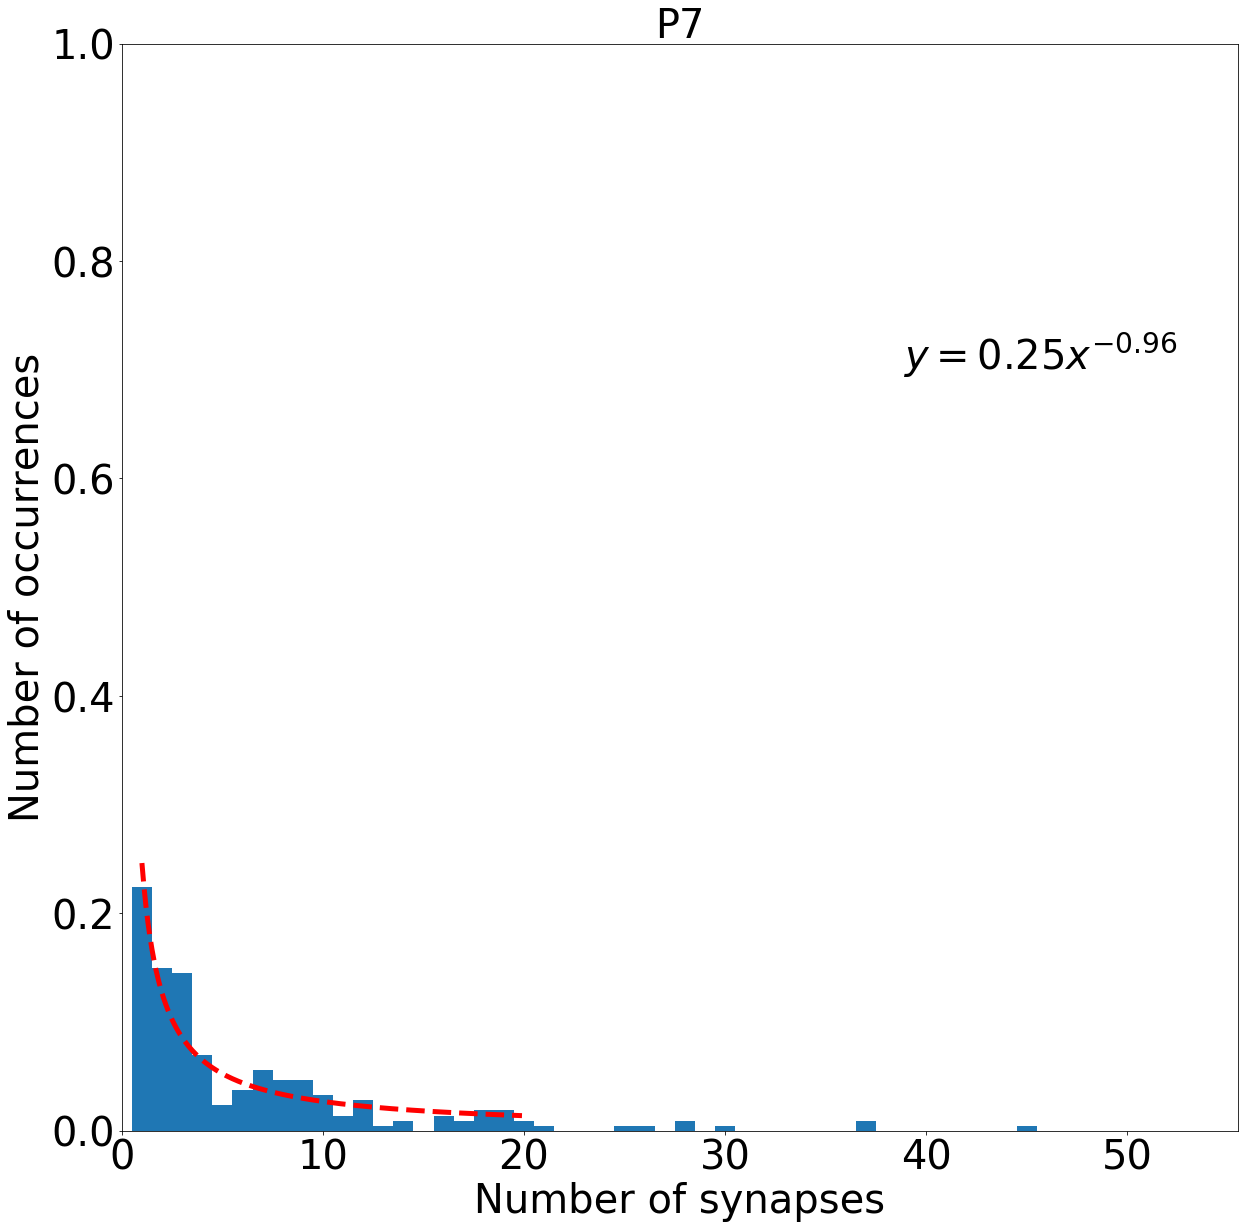

In [12]:
# visualize aggregated cf-pc connectivity at p3
plt.figure(figsize=(20,20))
edges_pc_conn = np.arange(5,465,10)*0.1
conn_obs_nz = [q for q in PCconnectivity.flatten() if q != 0]
hAllConnectivity = plt.hist(conn_obs_nz,bins=edges_pc_conn,density=True)
uxlim = np.max(hAllConnectivity[1]+10)
uylim = np.max([1,np.max(hAllConnectivity[0])])
plt.xlim((0,uxlim))
plt.ylim((0,uylim))
plt.xlabel('Number of synapses',fontsize=FS) # formed by one cf branch onto one pc target
plt.ylabel('Number of occurrences',fontsize=FS)
plt.title('P7',fontsize=FS)
plt.tick_params(labelsize=FS)
fignametemp = './data/figures/connectivity_patterns/p7_connectivity_all_axons_onto_all_pcs_nsyns.png'
# fit the aggregated connectivity with a power law.
histvalsforfit = hAllConnectivity[0]
histbincentersforfit = [0.5*j for j in [hAllConnectivity[1][q]+hAllConnectivity[1][q+1] for q in range(len(hAllConnectivity[1])-1)]]
params,params_covariance = optimize.curve_fit(powerlaw,histbincentersforfit,histvalsforfit,p0=[1,145])
xfitplot = np.arange(1,20,0.1)
plt.plot(xfitplot,powerlaw(xfitplot,params[0],params[1]),'r--',linewidth=5)
plt.text(0.7*uxlim,0.7*uylim,'$y = {0:.2f}x^{{-{1:.2f}}}$'.format(params[1],params[0]),fontsize=FS)
# plt.show()
plt.savefig(fignametemp)

# print fit parameters and the standard deviation on each parameter (from the diagonal
# of the covariance matrix)
params_std = np.sqrt(np.diag(params_covariance))
print('fit gamma = {0:.2f} +/- {1:.2f}; fit c0 = {2:.2f} +/- {3:.2f}'.format(params[0],params_std[0],params[1],params_std[1]))

In [13]:
print(np.mean(conn_obs_nz),np.std(conn_obs_nz),np.median(conn_obs_nz))

6.331775700934579 7.141246496220628 3.0


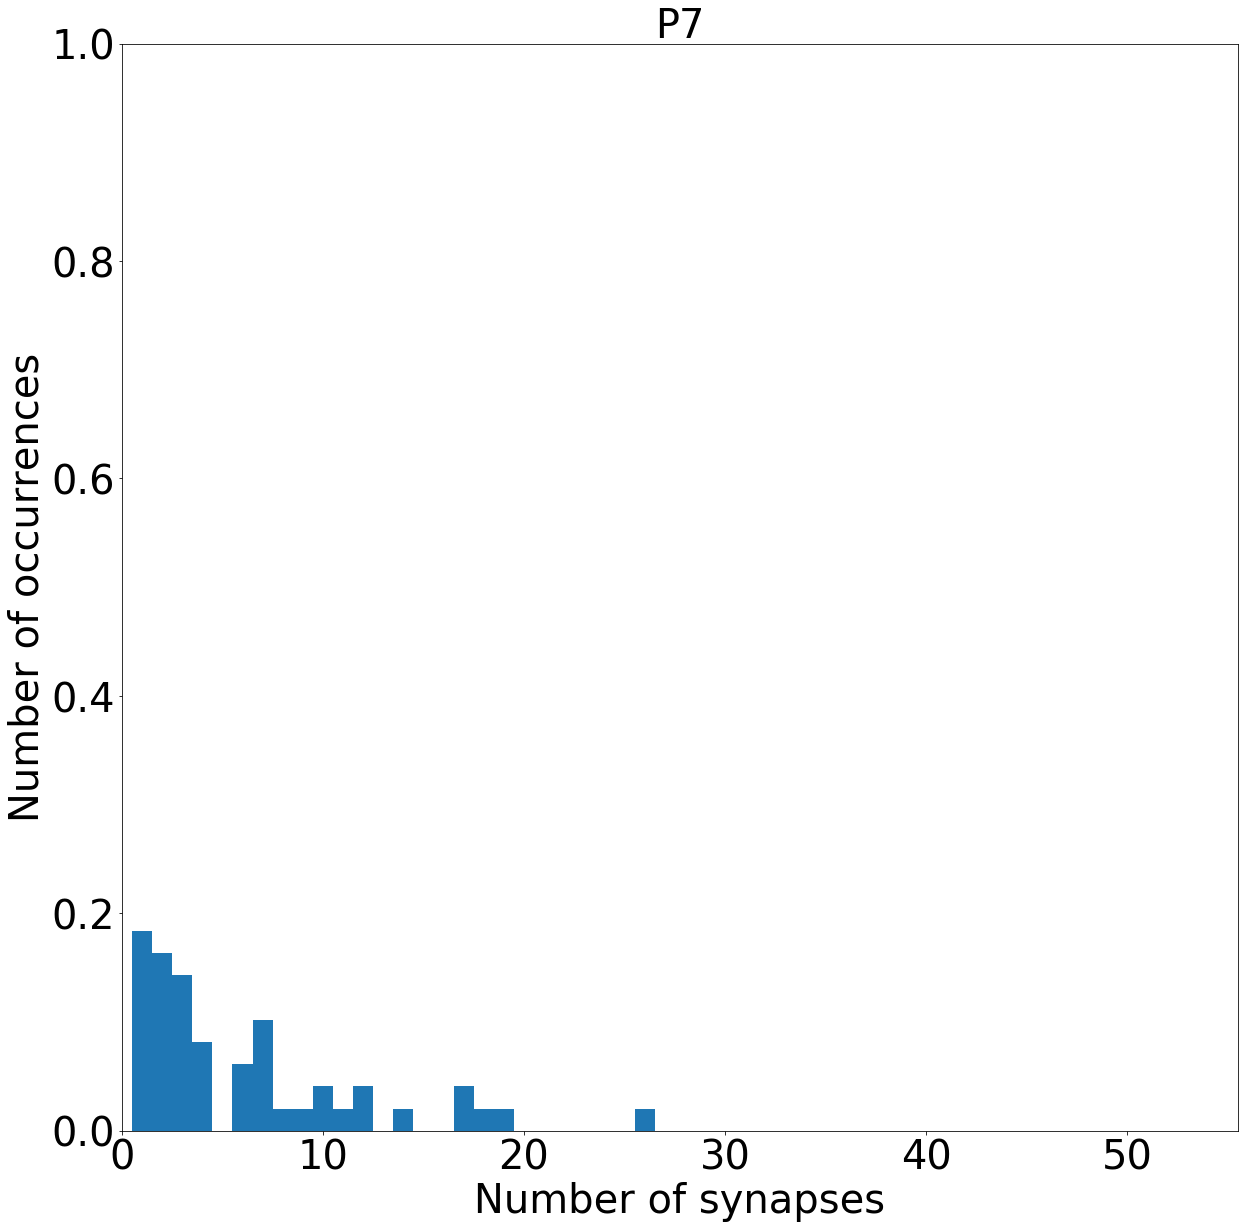

In [14]:
# visualize connectivity onto fully reconstructed cell at p7
plt.figure(figsize=(20,20))
conn_fr_pc = PCconnectivity[:,0]
conn_fr_obs_nz = [q for q in conn_fr_pc.flatten() if q != 0]
hfrConnectivity = plt.hist(conn_fr_obs_nz,bins=edges_pc_conn,density=True)
uxlim = np.max(hAllConnectivity[1]+10)
uylim = np.max([1,np.max(hAllConnectivity[0])])
plt.xlim((0,uxlim))
plt.ylim((0,uylim))
plt.xlabel('Number of synapses',fontsize=FS) # formed by one cf branch onto one pc target
plt.ylabel('Number of occurrences',fontsize=FS)
plt.title('P7',fontsize=FS)
plt.tick_params(labelsize=FS)
fignametemp = './data/figures/connectivity_patterns/p7_connectivity_all_axons_onto_fr_pc_nsyns.png'

# plt.show()
plt.savefig(fignametemp)

In [15]:
print(np.mean(conn_fr_obs_nz),np.std(conn_fr_obs_nz),np.median(conn_fr_obs_nz))

6.081632653061225 5.710129683983839 4.0


In [16]:
# Monte Carlo to test whether skew and median are consistent with a scheme in which PC targets are random

# Set up pools of potential synaptic targets for each axon
CFPCtargs = []
CFntargs  = []
for currax in VASTIDnew:
    curraxtargrows = [q for i,q in enumerate(targIDnew) if VASTIDnew[i] == currax]
    curraxtargs    = [q for q in list(set(curraxtargrows)) if q != -999]
    CFPCtargs.append(curraxtargs)
    CFntargs.append(len(curraxtargs))

# Construct a list of lists containing the rows of all synapses for each cf in the observed data
CFrows    = []
for currax in uinputnew:
    curraxrows = [i for i,q in enumerate(VASTIDnew) if q == currax]
    CFrows.append(curraxrows)

# Set Monte Carlo parameters
seedcurr = 189 # random seed for repeatable results
random.seed(seedcurr)
nrandseq = 100000 # number of iterations

# Initialize arrays to store results
conn_all_mcs = np.zeros((PCconnectivity.shape[0],PCconnectivity.shape[1],nrandseq))
mean_each_mc_nz = []
# skew_each_mc_nz = [] # manually computed skewness about the mean
median_each_mc_nz = []
skew_py_each_mc_nz = []

# Find locations of zeros in the cf-pc connectivity matrix (PCconnectivity)
# so they can be removed when computing distribution properties
roz,coz = np.where(PCconnectivity == 0)

for q in range(nrandseq):
    # Generate a random number to select an index in the list of pc targs for every synapse
    targidsrandcurr = [random.randint(0,CFntargs[k]-1) for k in range(len(VASTIDnew))]
    PCtargsMCcurr = [CFPCtargs[k][targidsrandcurr[k]] for k in range(len(VASTIDnew))]

    conn_mc_curr = np.zeros((PCconnectivity.shape[0],PCconnectivity.shape[1]))
    for rid in range(len(uinputnew)):
        rowscurr = CFrows[rid]
        ntargscfcurr = CFntargs[rowscurr[0]] # number of pcs innervated by the current cf
        for tid in range(ntargscfcurr): 
            # iterate through each of the purkinje cell targets and count the new number of
            # synapses formed onto it by the current cf
            PCcurr = CFPCtargs[rowscurr[0]][tid]
            cid = [i for i,k in enumerate(utargnew) if k == PCcurr][0] # find the column for the current pc
            pctargscfcurr = [PCtargsMCcurr[k] for k in rowscurr]
            conn_mc_curr[rid,cid] = len([k for k in pctargscfcurr if k == PCcurr])
    
    # Mark the observed zeros (found above) with a negative number to distinguish
    # them from zeros that arose from the Monte Carlo randomization.
    OBSERVEDZEROTAG = -1111
    conn_mc_currwoztag = conn_mc_curr
    for k in range(len(roz)):
        conn_mc_currwoztag[roz[k],coz[k]] = OBSERVEDZEROTAG
    conn_all_mcs[:,:,q] = conn_mc_currwoztag
    # Remove Monte-Carlo-produced zeros here to be consistent with the
    # removal of zeros in the observed distribution    
    PCconnectivityEachMCnozeroscurr = np.asarray([k for k in conn_mc_currwoztag.flatten() if ((k != 0) and (k != OBSERVEDZEROTAG))])
    
#     # Calculate connectivity matrix mean and skewness
#     mean_each_mc_nzcurr  = np.mean(PCconnectivityEachMCnozeroscurr)
#     mean_each_mc_nz.append(mean_each_mc_nzcurr)
#     stdPCconnectivityEachMCnozeroscurr   = np.std(PCconnectivityEachMCnozeroscurr)
#     skew_each_mc_nzcurr   = np.mean( [((k - mean_each_mc_nzcurr)/stdPCconnectivityEachMCnozeroscurr)**3 for k in PCconnectivityEachMCnozeroscurr] )
#     skew_each_mc_nz.append(skew_each_mc_nzcurr)
    
    skew_py_each_mc_nz.append(st.skew(PCconnectivityEachMCnozeroscurr))   
    median_each_mc_nz.append(np.median(PCconnectivityEachMCnozeroscurr))
    


In [17]:
# Save the data you produced
fname_mc_p7 = './data/mc_connectivity_experiment/190205_p7_obs_vs_mc_conn_niter_{0}.json'.format(nrandseq)
with open(fname_mc_p7,'w') as f:
    jsonobj = json.dumps({'all_mc_conn_mats':conn_all_mcs.flatten().tolist(),'skews':skew_py_each_mc_nz,'medians':median_each_mc_nz})
    f.write(jsonobj)

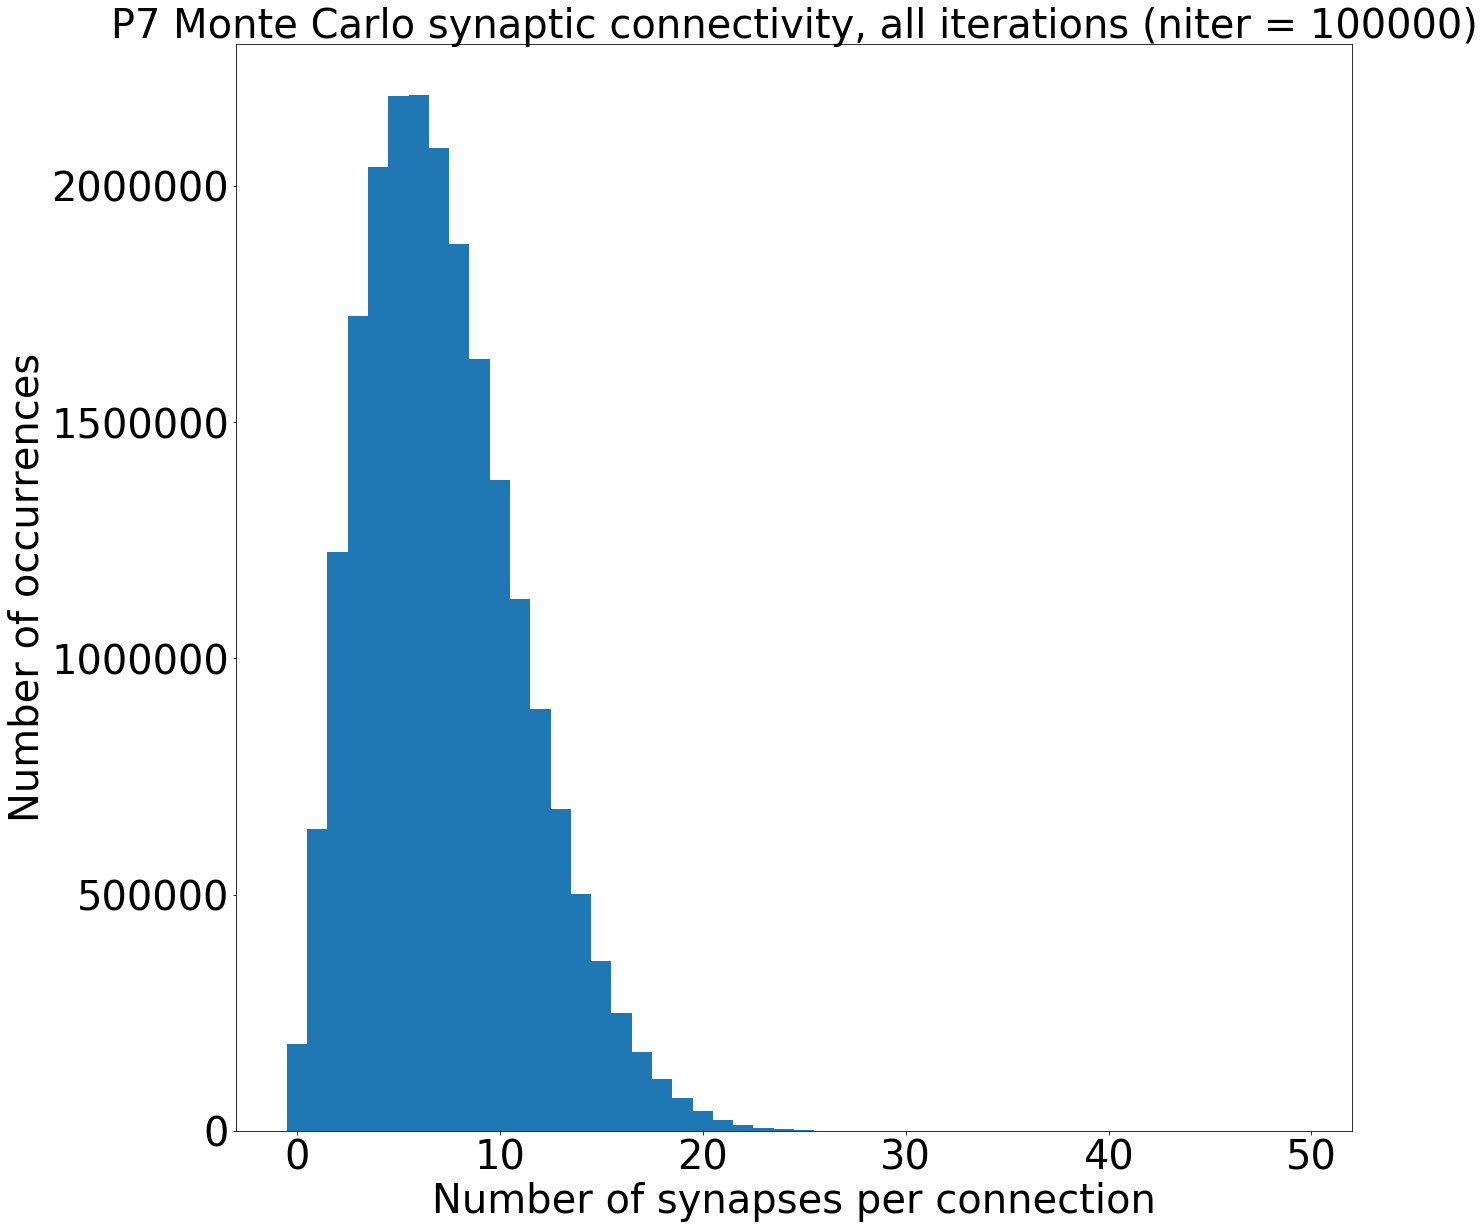

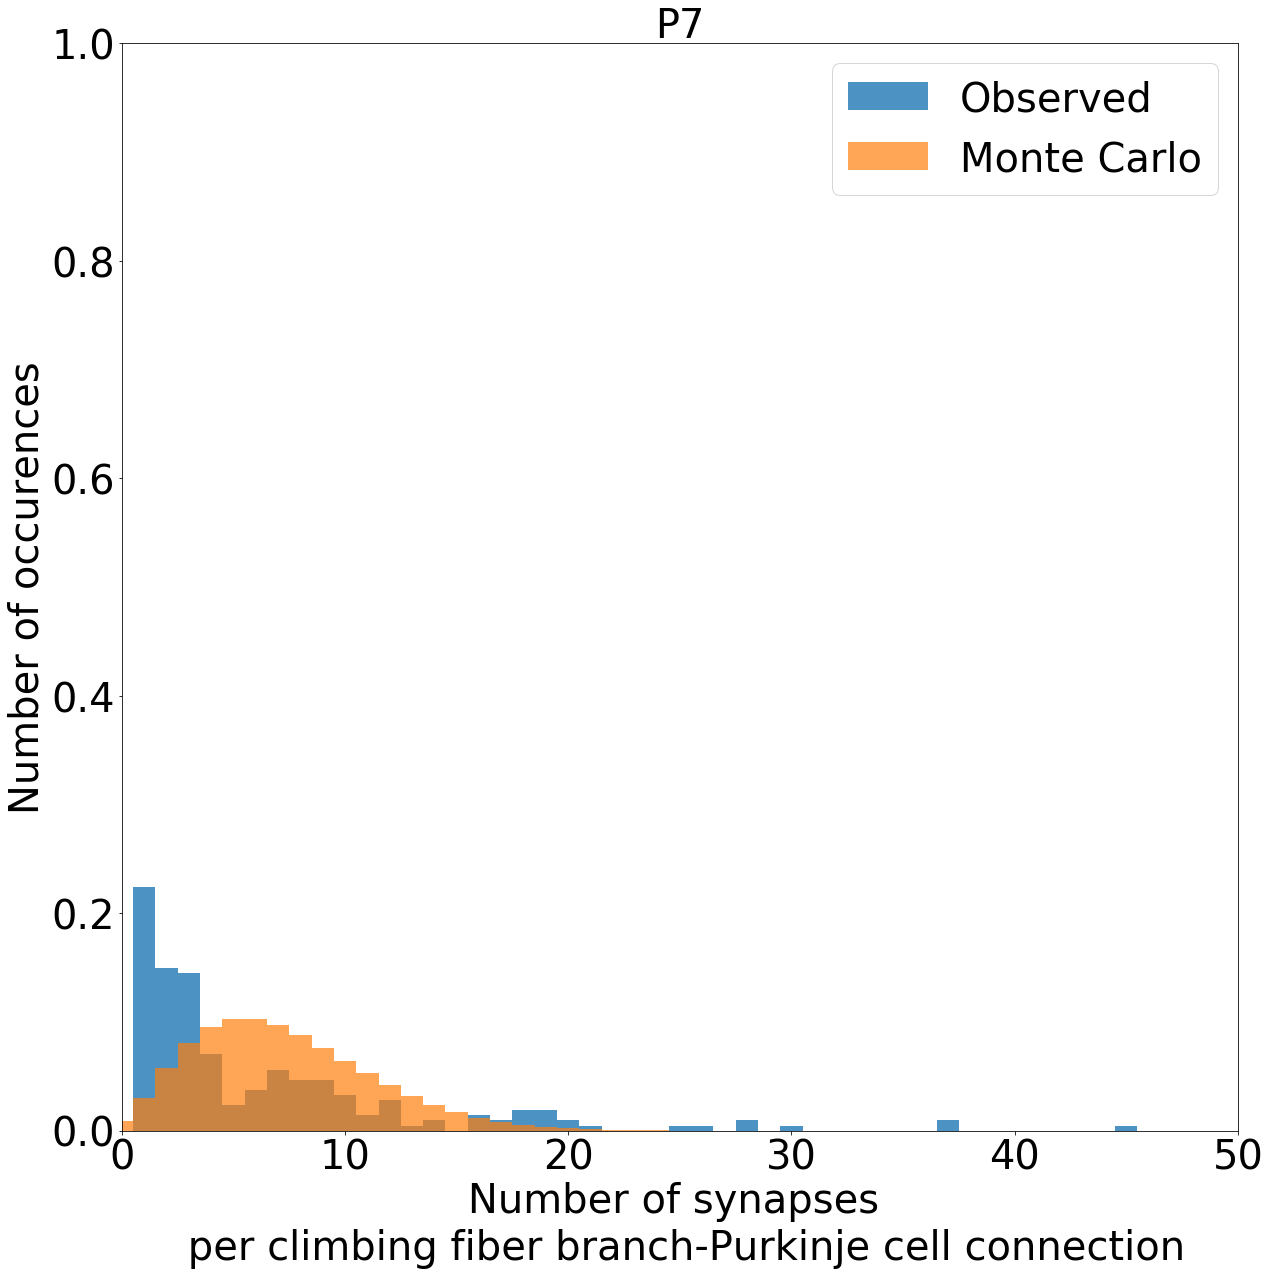

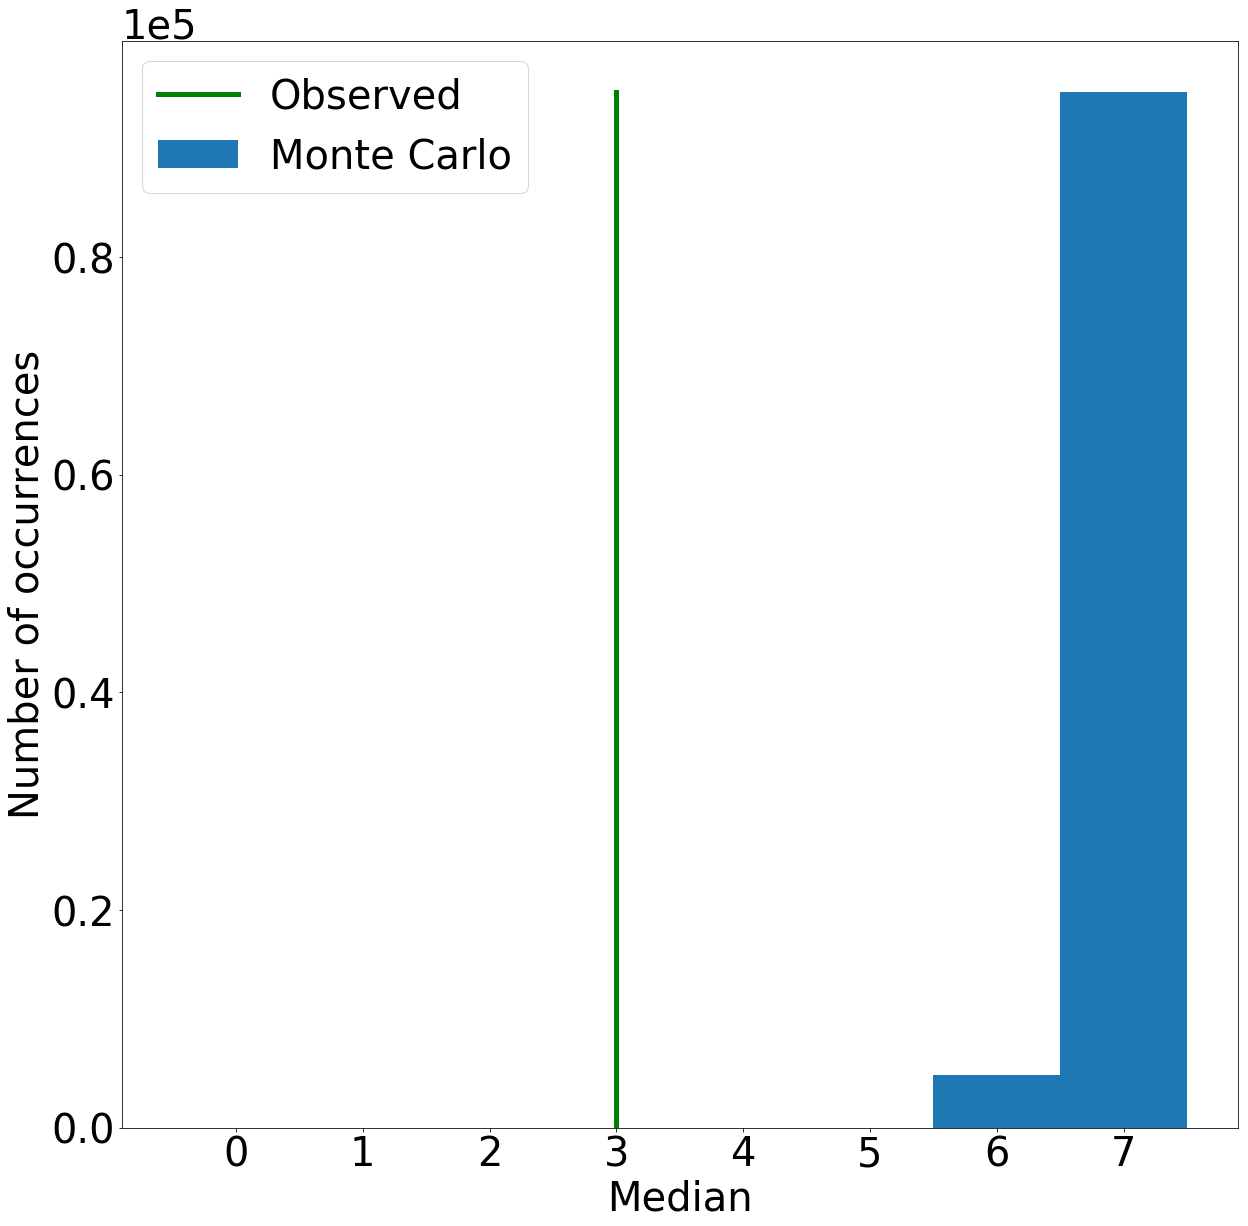

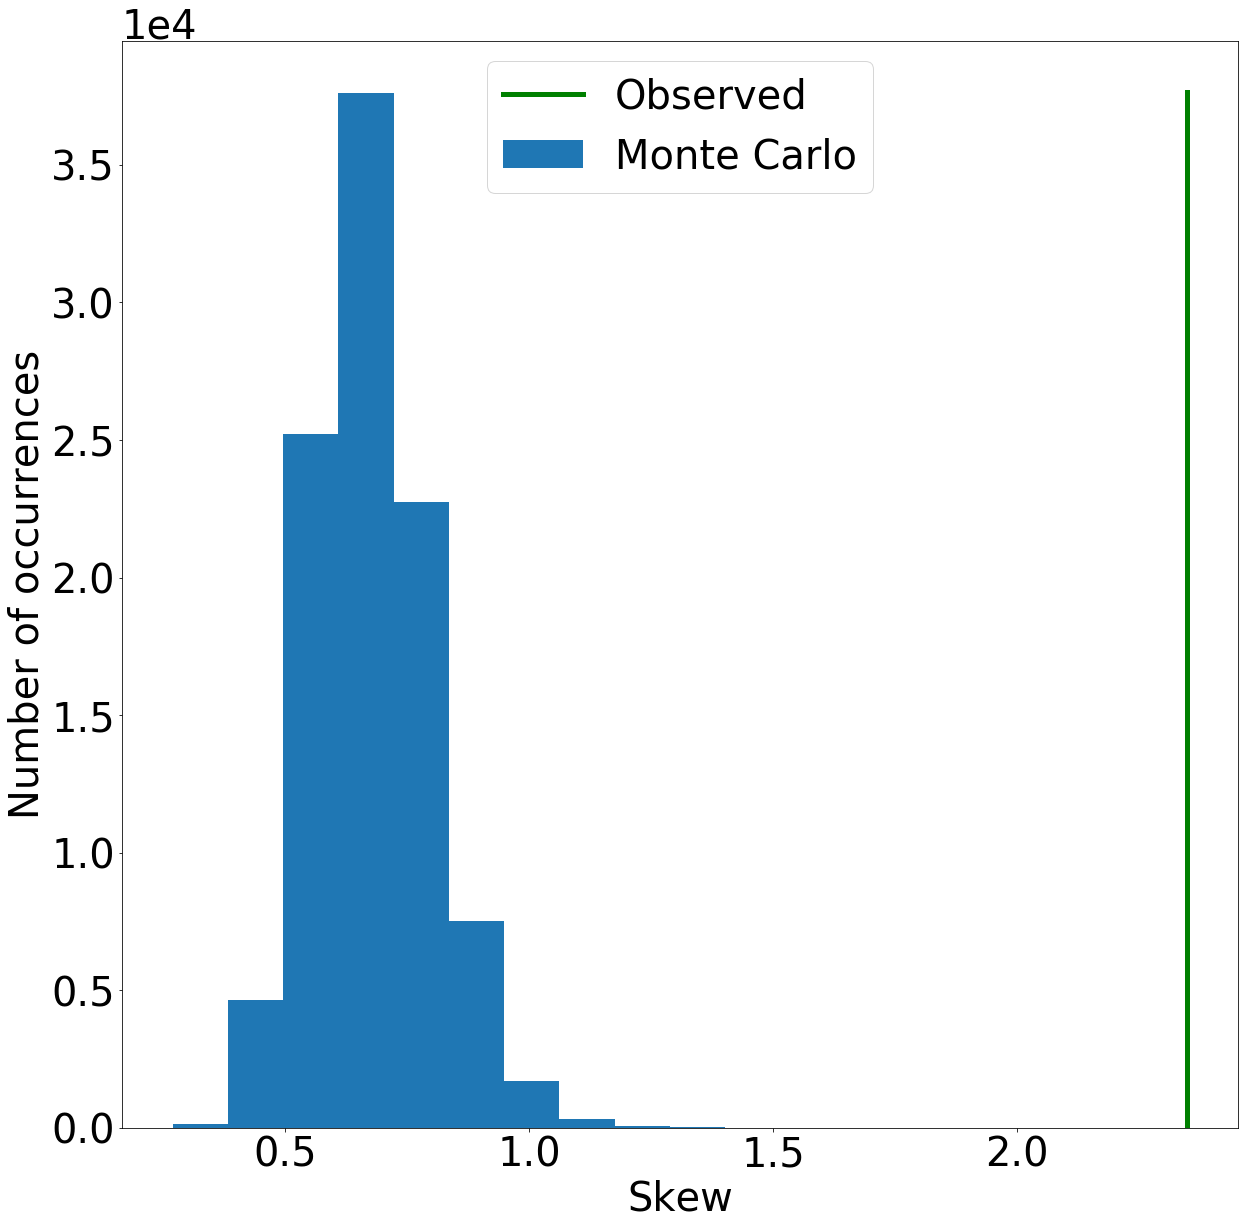

In [18]:
# Inspect the combined distribution from all MC runs
# (When comparing these distributions we use the two-sided p-value)

# Remove the observed zeros from the connectivity matrix
# (Alternatively, to see the observed zeros, change elements with tag to 0
conn_all_mcsnozeros = [q for q in conn_all_mcs.flatten() if q != OBSERVEDZEROTAG]

histbins_obs_mc = np.arange(-5,500,10)*0.1
plt.figure(figsize=(20,20))
hallMCnozeros = plt.hist(conn_all_mcsnozeros, bins=histbins_obs_mc)
plt.xlabel('Number of synapses per connection',fontsize=FS)
plt.ylabel('Number of occurrences',fontsize=FS)
plt.title('P7 Monte Carlo synaptic connectivity, all iterations (niter = {0})'.format(nrandseq),fontsize=FS)
plt.tick_params(labelsize=FS)
# plt.show()
figname_mc_conn = './data/figures/mc_conn_expt/p7_mc_conn_niter_{0}.png'.format(nrandseq)
plt.savefig(figname_mc_conn)

# Compare the normalized MC and observed distributions
plt.figure(figsize=(20,20))
plt.hist(conn_obs_nz, bins=histbins_obs_mc, density=True, label='Observed', alpha = 0.8)
plt.hist(conn_all_mcsnozeros, bins=histbins_obs_mc, density=True, label='Monte Carlo', alpha = 0.7)
plt.xlim((0,50)) # limits are set to be the same for both p3 and p7 plots
plt.ylim((0,1.0))
plt.xlabel('Number of synapses \n per climbing fiber branch-Purkinje cell connection',fontsize=FS)
plt.ylabel('Number of occurences',fontsize=FS)
plt.title('P7',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
plt.tick_params(labelsize=FS)
# plt.show()
figname_comp = './data/figures/mc_conn_expt/p7_obs_mc_norm_dist_comparison_niter_{0}.png'.format(nrandseq)
plt.savefig(figname_comp)

# SKIP THIS SKEW MEASUREMENT SINCE IT'S IDENTICAL TO THE SCIPY ONE AND SCIPY PROBABLY DOES IT FASTER
# # Compare manually computed skewness about the mean between mc and observed distributions
# mean_obs_nz = np.mean(conn_obs_nz)
# std_obs_nz = np.std(conn_obs_nz)
# skew_obs_arg = [((conn_obs_nz[q] - mean_obs_nz)/std_obs_nz)**3 for q in range(len(conn_obs_nz))]
# skew_obs_nz = np.mean(skew_obs_arg)
# skew_py_obs_nz = st.skew(conn_obs_nz)
# # Calculate p-value for manually calculated skew
# muskewallMC = np.mean(skew_each_mc_nz)
# obsMCdiffskewall = np.abs(skew_obs_nz - muskewallMC)
# upperlimskewall = muskewallMC + obsMCdiffskewall
# lowerlimskewall = muskewallMC - obsMCdiffskewall
# ninlimsskewall = len([q for q in skew_each_mc_nz if ((q > lowerlimskewall) and (q < upperlimskewall))])
# fracmoreextremeskewall = 1 - (ninlimsskewall/len(skew_each_mc_nz))
# # Show both
# plt.figure(figsize=(10,10))
# hskewnessabtmean = plt.hist(skew_each_mc_nz,label='monte carlo')
# plt.plot([skew_obs_nz,skew_obs_nz],[0,np.max(hskewnessabtmean[0])+10],'g',label='observed')
# plt.xlabel('skew, manual calculation',fontsize=FS)
# plt.ylabel('number of occurrences',fontsize=FS)
# plt.legend(loc='best',fontsize=FS)
# plt.show()

# Compare medians of MC and observed distributions
medianconn_obs_nz = np.median(conn_obs_nz)
# Calculate p-value
mumedianallMC = np.mean(median_each_mc_nz)
obsMCdiffmedianall = np.abs(medianconn_obs_nz - mumedianallMC)
upperlimmedianall = mumedianallMC + obsMCdiffmedianall
lowerlimmedianall = mumedianallMC - obsMCdiffmedianall
ninlimsmedianall = len([q for q in median_each_mc_nz if ((q > lowerlimmedianall) and (q < upperlimmedianall))])
fracmoreextrememedianall = 1 - (ninlimsmedianall/len(median_each_mc_nz))
# Show both
edges_medians = np.arange(-5,85,10)*0.1
plt.figure(figsize=(20,20))
ax=plt.subplot()
hmedians = plt.hist(median_each_mc_nz,bins=edges_medians,label='Monte Carlo')
plt.plot([medianconn_obs_nz,medianconn_obs_nz],[0,np.max(hmedians[0])+10],'g',label='Observed',linewidth=5)
plt.xlabel('Median',fontsize=FS)
plt.ylabel('Number of occurrences',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.tick_params(labelsize=FS)
ax.yaxis.get_offset_text().set_fontsize(FS)
# plt.show()
figname_median = './data/figures/mc_conn_expt/p7_median_obs_vs_mc_niter_{0}.png'.format(nrandseq)
plt.savefig(figname_median)

# Compare scipy skew for Monte Carlo and observed distributions
skew_py_obs_nz = st.skew(conn_obs_nz)
# Calculate p-value
muskewpyallmc = np.mean(skew_py_each_mc_nz)
obsdiffskewpyall = np.abs(skew_py_obs_nz - muskewpyallmc)
upperlimskewpyall = muskewpyallmc + obsdiffskewpyall
lowerlimskewpyall = muskewpyallmc - obsdiffskewpyall
ninlimsskewpyall = len([q for q in skew_py_each_mc_nz if ((q > lowerlimskewpyall) and (q < upperlimskewpyall))])
fracmoreextremeskewpyall = 1 - (ninlimsskewpyall/len(skew_py_each_mc_nz))
# Show both
plt.figure(figsize=(20,20))
ax=plt.subplot()
hskewpy = plt.hist(skew_py_each_mc_nz,label='Monte Carlo')
plt.plot([skew_py_obs_nz,skew_py_obs_nz],[0,np.max(hskewpy[0])+10],'g',label='Observed',linewidth=5)
plt.xlabel('Skew',fontsize=FS)
plt.ylabel('Number of occurrences',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.tick_params(labelsize=FS)
ax.yaxis.get_offset_text().set_fontsize(FS)
# plt.show()
figname_skew = './data/figures/mc_conn_expt/p7_skew_obs_vs_mc_niter_{0}.png'.format(nrandseq)
plt.savefig(figname_skew)

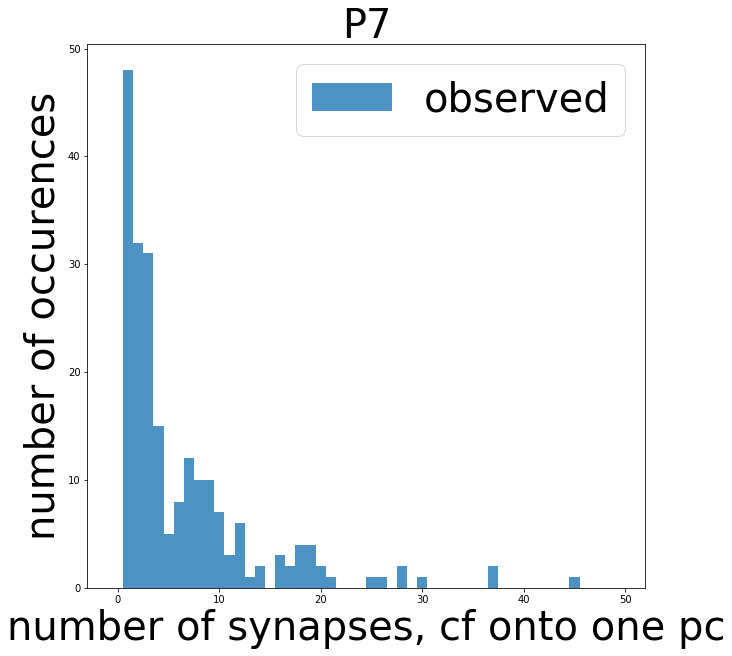

In [19]:
# Compare the normalized MC and observed distributions
plt.figure(figsize=(10,10))
plt.hist(conn_obs_nz, bins=histbins_obs_mc, label='observed', alpha = 0.8)
# plt.hist(conn_all_mcsnozeros, bins=histbins_obs_mc, density=True, label='monte carlo', alpha = 0.7)
# plt.xlim((0,50)) # limits are set to be the same for both p3 and p7 plots
# plt.ylim((0,0.70))
plt.xlabel('number of synapses, cf onto one pc',fontsize=FS)
plt.ylabel('number of occurences',fontsize=FS)
plt.title('P7',fontsize=FS)
plt.legend(loc='best',fontsize=FS)
# plt.show()

In [20]:
# Print p-values for median and skews of Monte Carlo vs. observed distributions
print('two-sided p-value for medians, niter {0} = {1}'.format(nrandseq,fracmoreextrememedianall))
print('two-sided p-value for skews, niter {0} = {1}'.format(nrandseq,fracmoreextremeskewpyall))

two-sided p-value for medians, niter 100000 = 0.0
two-sided p-value for skews, niter 100000 = 0.0


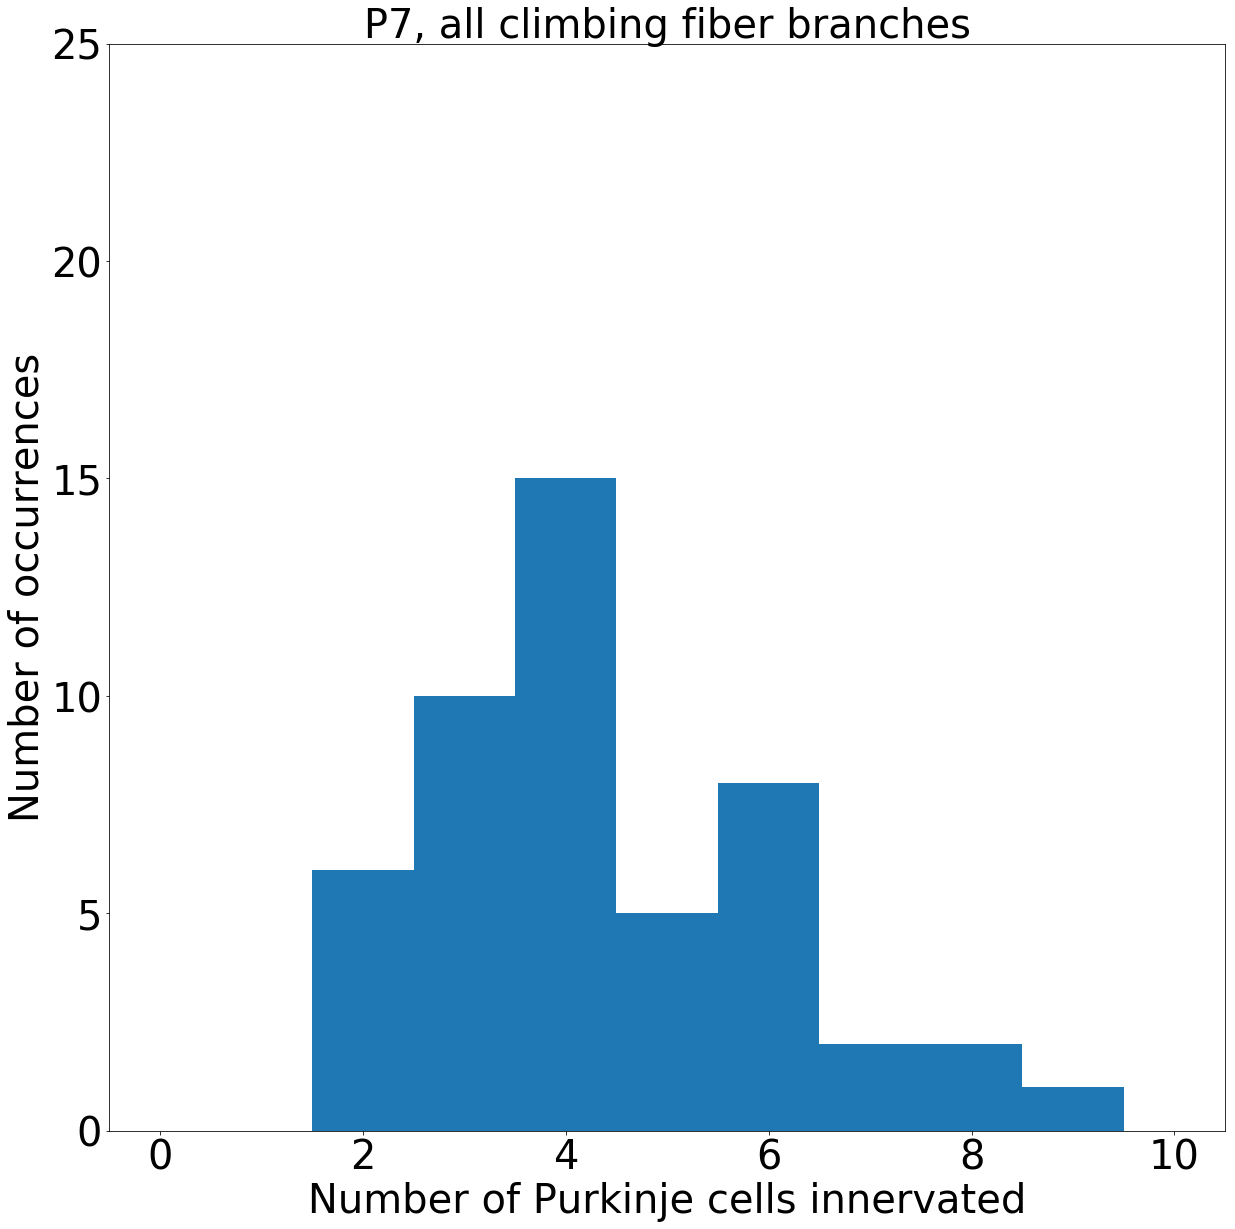

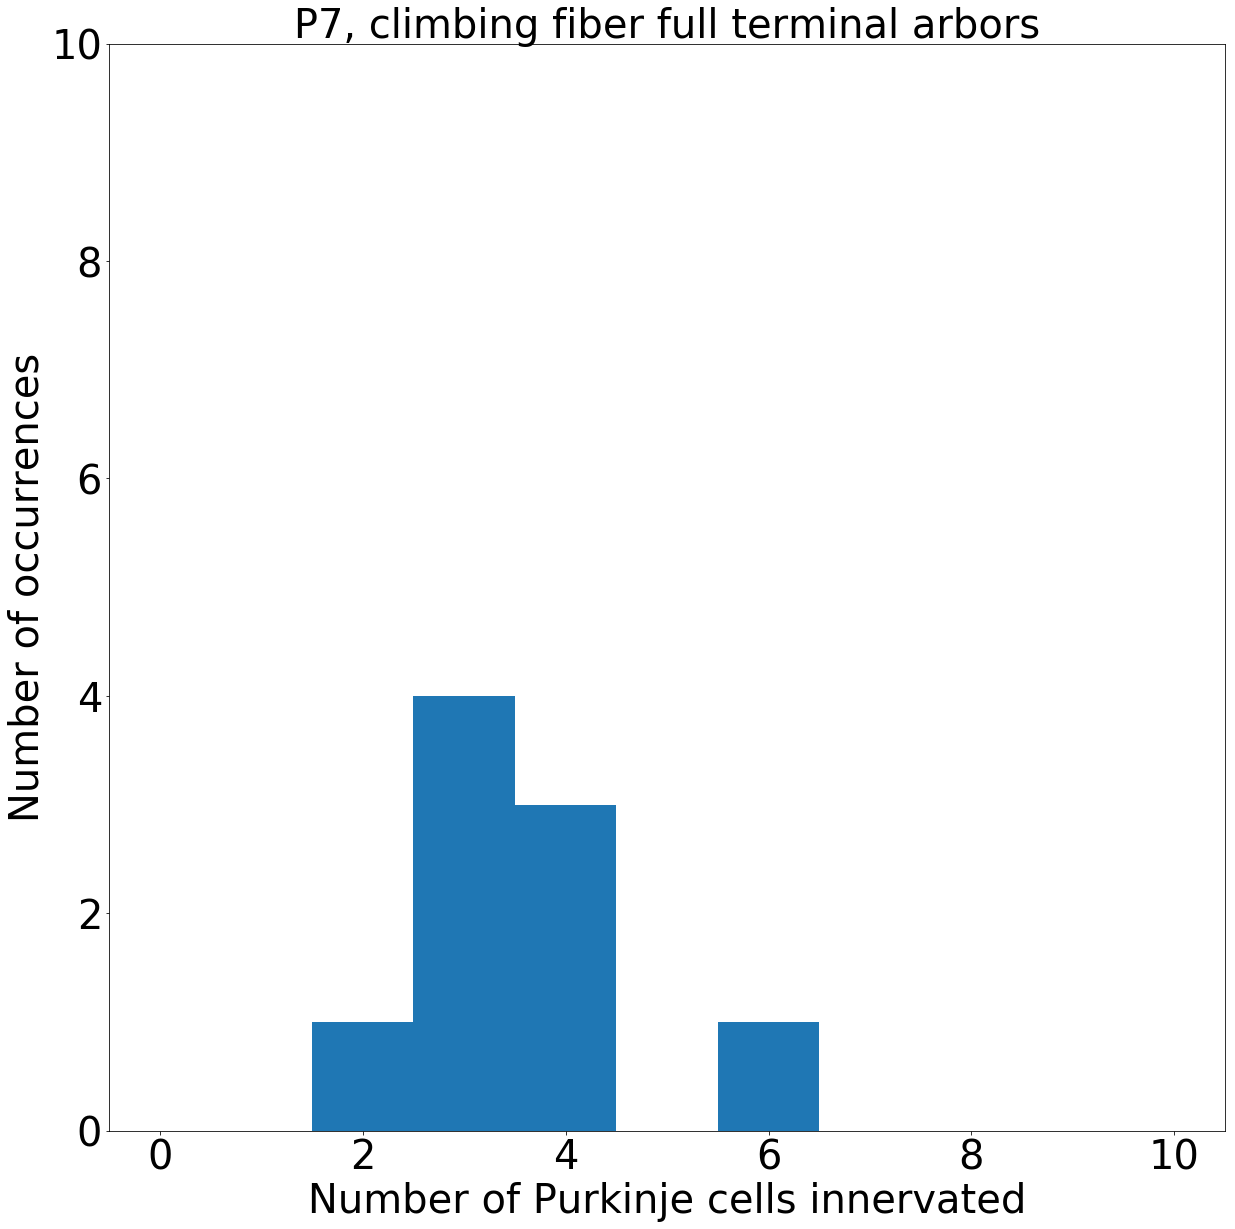

In [21]:
# Inspect CF divergence (the number of PCs innervated by each CF)
# Construct a binary connectivity matrix from the observed connectivity matrix
binaryPCconnectivity = np.zeros((PCconnectivity.shape[0],PCconnectivity.shape[1]))
rnz,cnz = np.where(PCconnectivity != 0)
for q in range(len(rnz)):
    binaryPCconnectivity[rnz[q],cnz[q]] = 1

nPCscontactedperCF = np.sum(binaryPCconnectivity,axis=1)
edges_nPCs = np.arange(-5,105,10)*0.1
plt.figure(figsize=(20,20))
plt.hist(nPCscontactedperCF,bins=edges_nPCs)
plt.xlim((-0.5,10.5))
plt.ylim((0,25))
plt.xlabel('Number of Purkinje cells innervated',fontsize=FS)
plt.ylabel('Number of occurrences',fontsize=FS)
# plt.title('P7 climbing fiber branch divergence',fontsize=FS)
plt.title('P7, all climbing fiber branches',fontsize=FS)
plt.tick_params(labelsize=FS)
# plt.show
figname_cf_div = './data/figures/cf_divergences/p7_npcspcf_all_cfs.png'
plt.savefig(figname_cf_div)

# Inspect the mean and standard deviation of CF divergence
meannPCscontactedperCF = np.mean(nPCscontactedperCF)
stdevnPCscontactedperCF = np.std(nPCscontactedperCF)
# print(meannPCscontactedperCF) # debugging
# print(stdevnPCscontactedperCF)

# Inspect divergence for only cfs with full terminal arbors in the volume
# (based upon visual inspection)
axonsfulltermarb = [7,11,12,18,22,24,26,35,53,54,55,61,63]
rowtokeepfulltermarb = [i for i,q in enumerate(uinputnew) if q in axonsfulltermarb]
nPCscontactedperCFfulltermarb = [nPCscontactedperCF[q] for q in rowtokeepfulltermarb]
plt.figure(figsize=(20,20))
plt.hist(nPCscontactedperCFfulltermarb,bins=edges_nPCs)
plt.xlim((-0.5,10.5))
plt.ylim((0,10))
plt.xlabel('Number of Purkinje cells innervated',fontsize=FS)
plt.ylabel('Number of occurrences',fontsize=FS)
# plt.title('P7 climbing fiber branch divergence, full terminal arbors',fontsize=FS)
plt.title('P7, climbing fiber full terminal arbors',fontsize=FS)
plt.tick_params(labelsize=FS)
# plt.show()
figname_cf_div_fta = './data/figures/cf_divergences/p7_npcspcf_cfs_ftas.png'
plt.savefig(figname_cf_div_fta)

# print(np.mean(nPCscontactedperCFfulltermarb)) #debugging
# print(np.std(nPCscontactedperCFfulltermarb))

In [22]:
# Save information about divergences of all CF branches
cd_div_fname_all = './data/cf_divergences/190205_p7_npcspercf.json'
with open(cd_div_fname_all,'w') as f:
    jsonobj = json.dumps({'p7_npcspercf_all':[int(q) for q in nPCscontactedperCF]})
    f.write(jsonobj)

# Save information about divergences of CFs with full terminal arbors
cd_div_fname = './data/cf_divergences/190205_p7_npcspercf_full_term_arbors.json'
with open(cd_div_fname,'w') as f:
    jsonobj = json.dumps({'p7_npcspercf_ftas':nPCscontactedperCFfulltermarb})
    f.write(jsonobj)